# UNDERVALUED GEMS SCOUT
## Clustering Analysis with K-Means

**Objective:** Apply K-Means clustering to identify distinct player profiles and automatically detect undervalued players (high performance, low salary).

**Methodology:**
- Feature selection: WAR, salary, BABIP, wOBA, ISO, K%
- Feature scaling using StandardScaler
- Optimal K determination via Silhouette Score
- K-Means clustering with k=3
- Cluster interpretation and undervalued group identification

**Author:** Moneyball Analytics
**Date:** 2026

In [2]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import os
import warnings
warnings.filterwarnings('ignore')

# Configure visual style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {pd.__version__}")

Libraries imported successfully
Pandas version: 2.2.2
NumPy version: 2.4.2
Scikit-learn version: 2.2.2


In [3]:
# =============================================================================
# LOAD CLEANED DATA
# =============================================================================

# Try multiple possible paths
possible_paths = [
    '../data/cleaned_undervalued_data.csv',
    '../data/analysis/players_2025_analysis.csv',
    '../data/top_undervalued_2025.csv'
]

df = None
for path in possible_paths:
    if os.path.exists(path):
        df = pd.read_csv(path)
        print(f"Data loaded successfully!")
        print(f"Path: {path}")
        print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
        break

if df is None:
    print("ERROR: No data file found!")
    print("Please run data_cleaner.py first.")

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())

Data loaded successfully!
Path: ../data/cleaned_undervalued_data.csv
Shape: 4,793 rows x 39 columns

First 5 rows:


,playerID,yearID,stint,teamID_x,lgID_x,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,teamID_y,lgID_y,salary,hits_per_ab,iso_lahman,k_rate_lahman,Name,WAR,wOBA,wRC_plus,BABIP,ISO,K%,value_ratio,babip_low_high_woba,power_contact,undervalued_score
0,judgeaa01,2024,1,NYA,AL,158,559,122,180,36,1,58,144.000,10.000,0.000,133,171.000,20.000,9.000,0.000,2.000,22.000,NaN,NaN,0.000,0.322,0.379,0.306,Aaron Judge,11.300,0.476,220.000,0.367,0.379,0.243,113.000,False,False,0.400
1,judgeaa01,2022,1,NYA,AL,157,570,133,177,28,0,62,131.000,16.000,3.000,111,175.000,19.000,6.000,0.000,5.000,14.000,NaN,NaN,0.000,0.311,0.375,0.307,Aaron Judge,11.100,0.458,206.000,0.340,0.375,0.251,111.000,False,False,0.394
2,bettsmo01,2018,1,BOS,AL,136,520,129,180,47,5,32,80.000,30.000,6.000,81,91.000,8.000,8.000,0.000,5.000,5.000,NaN,NaN,0.000,0.346,0.294,0.175,Mookie Betts,10.200,0.449,185.000,0.368,0.294,0.148,102.000,False,True,0.668
3,judgeaa01,2025,1,NYA,AL,152,541,137,179,30,2,53,114.000,12.000,5.000,124,160.000,36.000,7.000,0.000,7.000,16.000,NaN,NaN,0.000,0.331,0.357,0.296,Aaron Judge,10.100,0.463,204.000,0.376,0.357,0.236,101.000,False,False,0.365
4,troutmi01,2018,1,LAA,AL,140,471,101,147,24,4,39,79.000,24.000,2.000,122,124.000,25.000,10.000,0.000,4.000,5.000,NaN,NaN,0.000,0.312,0.316,0.263,Mike Trout,9.400,0.447,188.000,0.346,0.316,0.204,94.000,False,True,0.645


In [4]:
# =============================================================================
# FEATURE SELECTION FOR CLUSTERING
# =============================================================================

print("="*60)
print("FEATURE SELECTION")
print("="*60)

# Define features that capture player profiles
feature_columns = ['WAR', 'salary', 'BABIP', 'wOBA', 'ISO', 'K%']

# Check which features are available
available_features = [col for col in feature_columns if col in df.columns]

print(f"\nSelected features for clustering: {available_features}")
print(f"Number of features: {len(available_features)}")

if len(available_features) < 2:
    print("ERROR: Insufficient features for clustering")
    print("Need at least 2 features")

# Create feature matrix and handle missing values
feature_df = df[available_features].dropna()
print(f"\nFeature matrix shape: {feature_df.shape}")
print(f"Rows kept: {len(feature_df)} (dropped {len(df) - len(feature_df)} rows with missing values)")

# Store player information for later reference
id_columns = []
for col in ['playerID', 'Name', 'yearID', 'teamID']:
    if col in df.columns:
        id_columns.append(col)

player_info = df.loc[feature_df.index, id_columns].copy() if id_columns else pd.DataFrame(index=feature_df.index)
print(f"Player info shape: {player_info.shape}")

FEATURE SELECTION

Selected features for clustering: ['WAR', 'salary', 'BABIP', 'wOBA', 'ISO', 'K%']
Number of features: 6

Feature matrix shape: (4793, 6)
Rows kept: 4793 (dropped 0 rows with missing values)
Player info shape: (4793, 3)


FEATURE DISTRIBUTIONS

Feature statistics:


,WAR,salary,BABIP,wOBA,ISO,K%
count,4793.000,4793.000,4793.000,4793.000,4793.000,4793.000
mean,0.854,0.842,0.096,0.107,0.059,0.064
std,1.664,3.138,0.142,0.158,0.091,0.098
min,-2.500,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.100,0.000,0.276,0.311,0.139,0.155
max,11.300,28.000,0.412,0.478,0.379,0.439


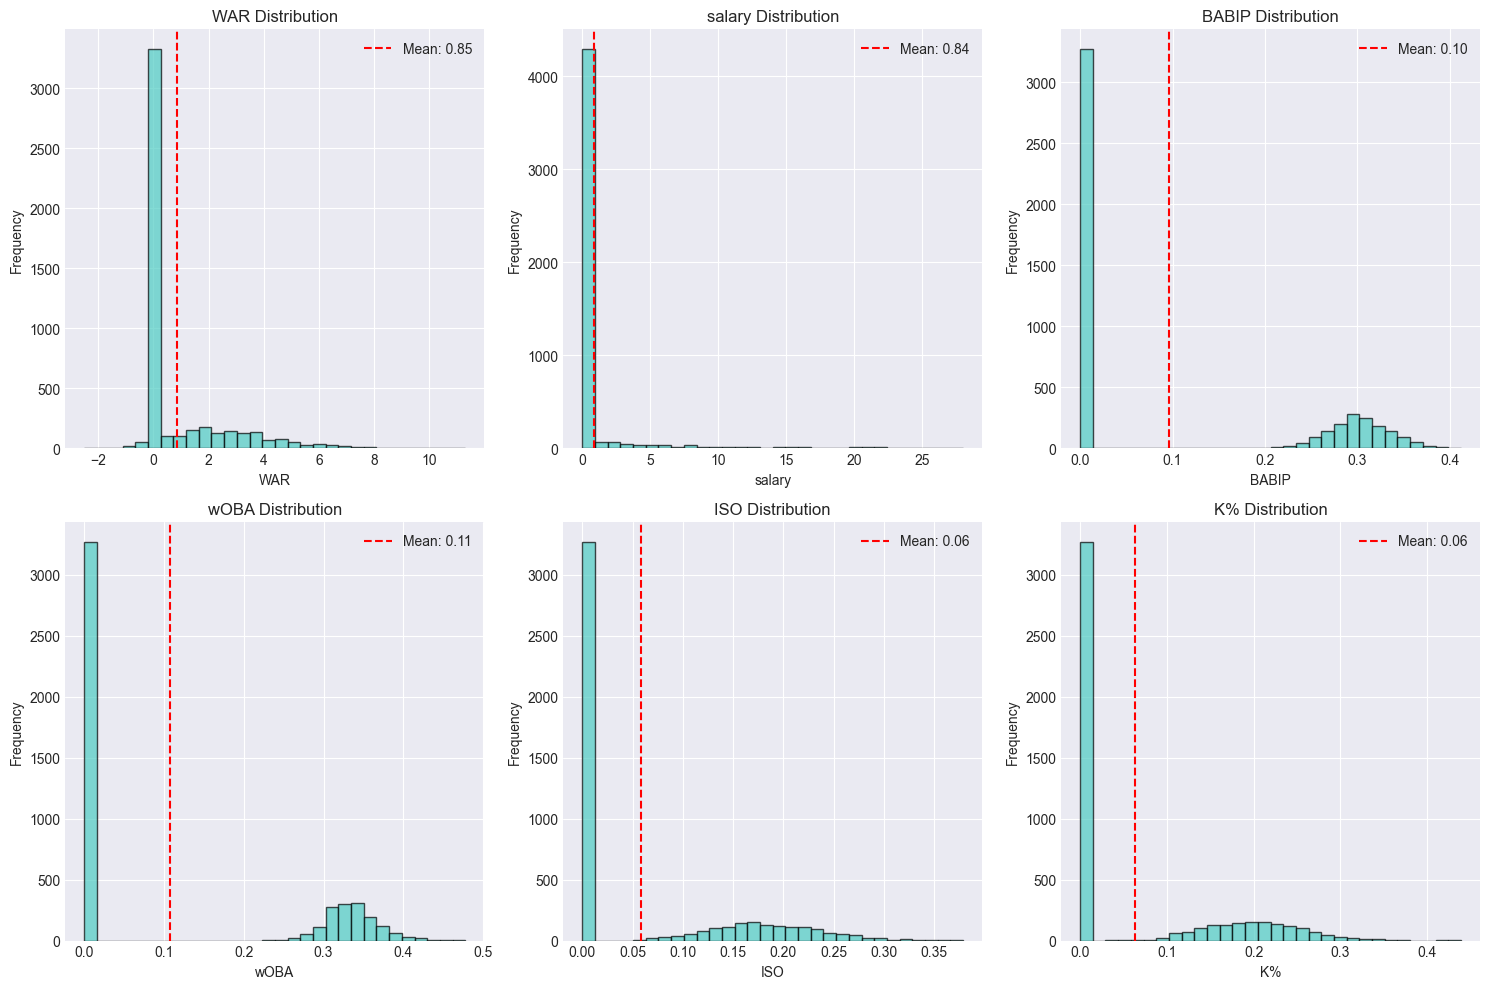

In [5]:
# =============================================================================
# FEATURE DISTRIBUTIONS
# =============================================================================

print("="*60)
print("FEATURE DISTRIBUTIONS")
print("="*60)

# Summary statistics
print("\nFeature statistics:")
display(feature_df.describe().round(3))

# Create distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(available_features):
    if i < len(axes):
        axes[i].hist(feature_df[col], bins=30, color='#4ecdc4', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].axvline(feature_df[col].mean(), color='red', linestyle='--', label=f'Mean: {feature_df[col].mean():.2f}')
        axes[i].legend()

# Hide unused subplots
for i in range(len(available_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

FEATURE SCALING

Scaled features (mean ≈ 0, standard deviation ≈ 1):


,WAR,salary,BABIP,wOBA,ISO,K%
count,4793.000,4793.000,4793.000,4793.000,4793.000,4793.000
mean,0.000,0.000,-0.000,-0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.020,-0.270,-0.680,-0.680,-0.640,-0.650
25%,-0.510,-0.270,-0.680,-0.680,-0.640,-0.650
50%,-0.510,-0.270,-0.680,-0.680,-0.640,-0.650
75%,0.150,-0.270,1.270,1.290,0.880,0.930
max,6.280,8.660,2.230,2.350,3.520,3.810



Mean of scaled features: -0.000000 (should be ~0)
Std of scaled features: 1.000104 (should be ~1)


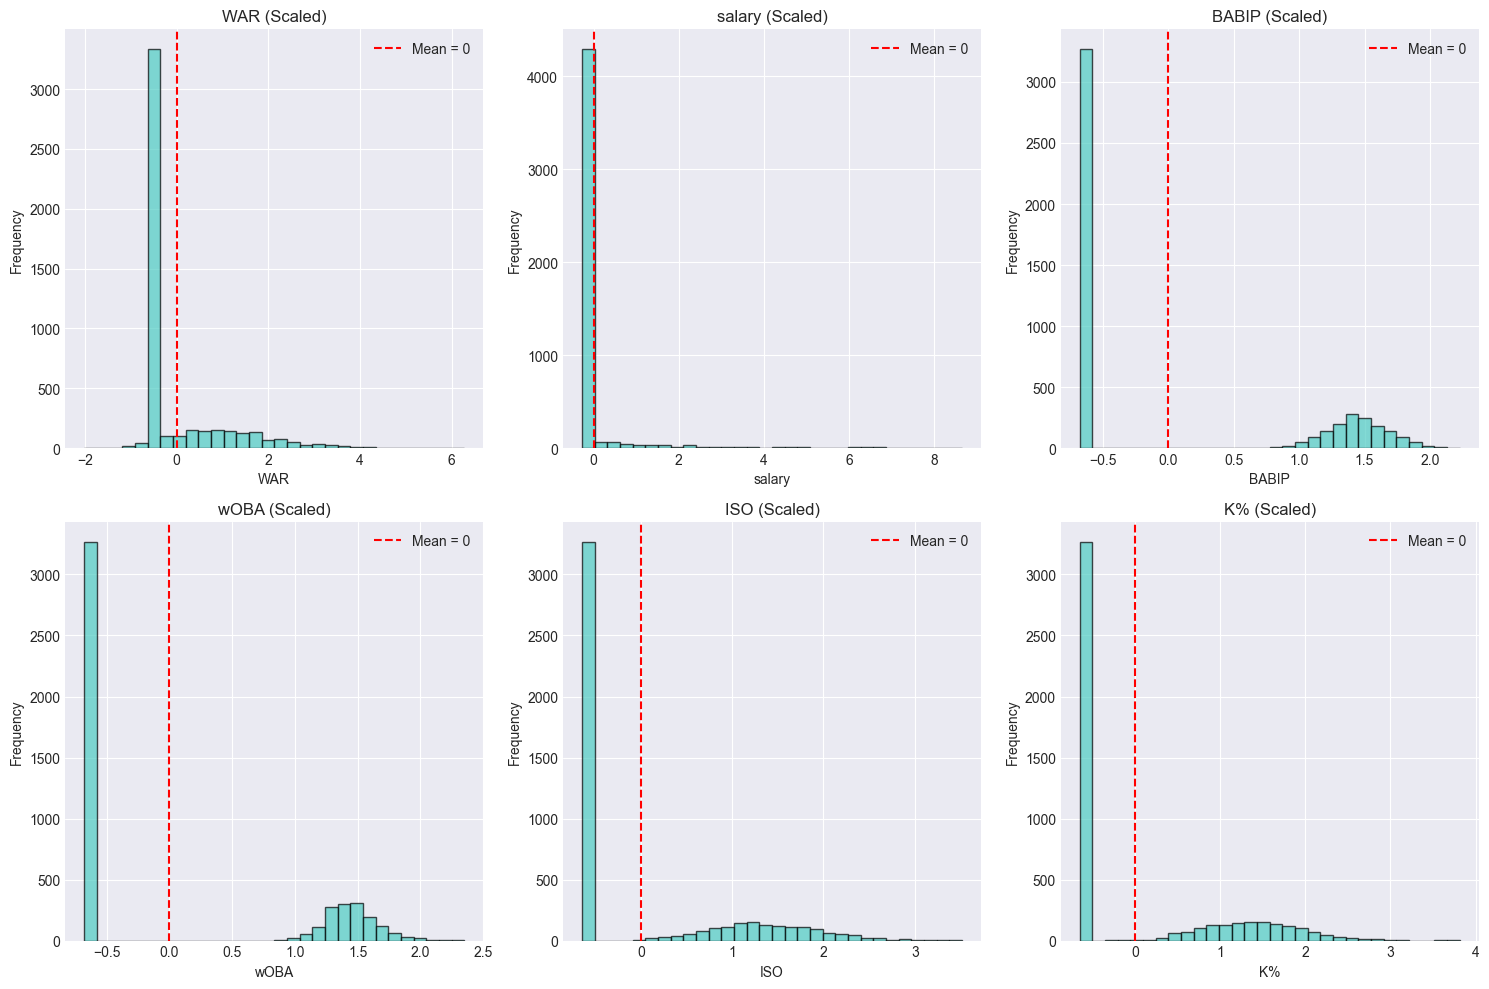

In [6]:
# =============================================================================
# FEATURE SCALING
# =============================================================================

print("="*60)
print("FEATURE SCALING")
print("="*60)

# K-Means is distance-based, so scaling is crucial
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(feature_df)

# Convert back to DataFrame for visualization
scaled_df = pd.DataFrame(feature_scaled, columns=available_features, index=feature_df.index)

print("\nScaled features (mean ≈ 0, standard deviation ≈ 1):")
display(scaled_df.describe().round(2))

# Verify scaling worked
print(f"\nMean of scaled features: {scaled_df.mean().mean():.6f} (should be ~0)")
print(f"Std of scaled features: {scaled_df.std().mean():.6f} (should be ~1)")

# Visualize scaled distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(available_features):
    if i < len(axes):
        axes[i].hist(scaled_df[col], bins=30, color='#4ecdc4', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'{col} (Scaled)')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].axvline(0, color='red', linestyle='--', label='Mean = 0')
        axes[i].legend()

# Hide unused subplots
for i in range(len(available_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

ELBOW METHOD FOR OPTIMAL K
K=1: Inertia=28758.00
K=2: Inertia=7979.80
K=3: Inertia=4984.49
K=4: Inertia=3655.84
K=5: Inertia=2923.04
K=6: Inertia=2527.13
K=7: Inertia=2248.76
K=8: Inertia=1972.67
K=9: Inertia=1745.68
K=10: Inertia=1598.69


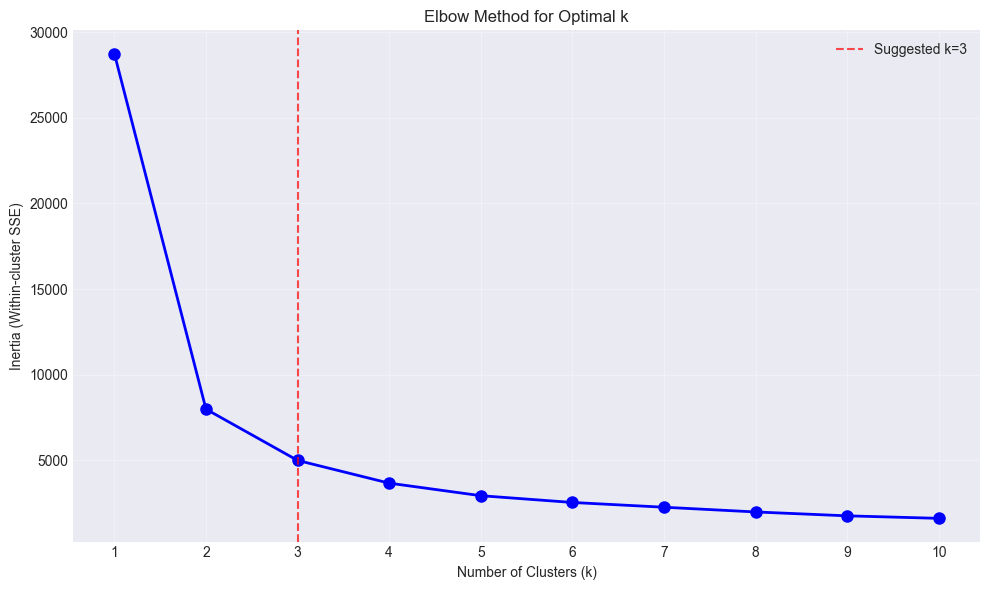


The elbow appears to bend around k=3, suggesting this as a good candidate.


In [7]:
# =============================================================================
# DETERMINE OPTIMAL K - ELBOW METHOD
# =============================================================================

print("="*60)
print("ELBOW METHOD FOR OPTIMAL K")
print("="*60)

# Test different values of K
k_range = range(1, 11)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(feature_scaled)
    inertias.append(kmeans.inertia_)
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}")

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

# Add vertical line at potential elbow (k=3)
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='Suggested k=3')

plt.legend()
plt.tight_layout()
plt.show()

print("\nThe elbow appears to bend around k=3, suggesting this as a good candidate.")

SILHOUETTE SCORE FOR OPTIMAL K
K=2: Silhouette Score=0.8014
K=3: Silhouette Score=0.8245
K=4: Silhouette Score=0.7529
K=5: Silhouette Score=0.7559
K=6: Silhouette Score=0.7361
K=7: Silhouette Score=0.7356
K=8: Silhouette Score=0.7325
K=9: Silhouette Score=0.7281
K=10: Silhouette Score=0.7217

Optimal K based on silhouette score: 3 (score=0.8245)


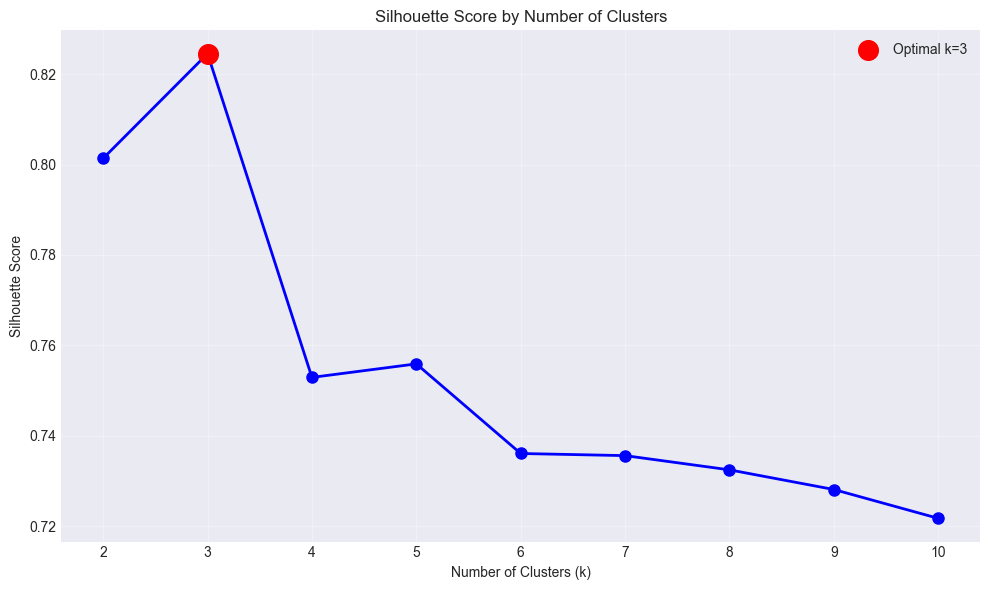


Interpretation of Silhouette Score:
- > 0.7: Strong structure (well-separated clusters)
- 0.5 - 0.7: Reasonable structure
- 0.3 - 0.5: Weak structure
- Our score of 0.8245 indicates strong cluster structure


In [8]:
# =============================================================================
# DETERMINE OPTIMAL K - SILHOUETTE SCORE
# =============================================================================

print("="*60)
print("SILHOUETTE SCORE FOR OPTIMAL K")
print("="*60)

# Silhouette score requires at least 2 clusters
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(feature_scaled)
    score = silhouette_score(feature_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score={score:.4f}")

# Find best k
best_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal K based on silhouette score: {best_k} (score={max(silhouette_scores):.4f})")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

# Mark optimal k
plt.scatter(best_k, max(silhouette_scores), color='red', s=200, zorder=5,
           label=f'Optimal k={best_k}')

plt.legend()
plt.tight_layout()
plt.show()

print("\nInterpretation of Silhouette Score:")
print("- > 0.7: Strong structure (well-separated clusters)")
print("- 0.5 - 0.7: Reasonable structure")
print("- 0.3 - 0.5: Weak structure")
print(f"- Our score of {max(silhouette_scores):.4f} indicates {'strong' if max(silhouette_scores) > 0.7 else 'reasonable'} cluster structure")

In [9]:
# =============================================================================
# APPLY K-MEANS CLUSTERING
# =============================================================================

print("="*60)
print("K-MEANS CLUSTERING")
print("="*60)

# Use optimal k found above
n_clusters = best_k
print(f"Applying K-Means with k={n_clusters}")

# Initialize and fit K-Means
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init=10,
    max_iter=300
)

# Predict cluster labels
cluster_labels = kmeans.fit_predict(feature_scaled)

# Add cluster labels to player info
player_info_with_clusters = player_info.copy()
player_info_with_clusters['cluster'] = cluster_labels

# Add feature values back for analysis
for col in available_features:
    player_info_with_clusters[col] = feature_df[col].values

# Count players per cluster
cluster_counts = player_info_with_clusters['cluster'].value_counts().sort_index()

print("\nCluster Distribution:")
for cluster in range(n_clusters):
    count = cluster_counts.get(cluster, 0)
    percentage = count / len(player_info_with_clusters) * 100
    print(f"Cluster {cluster}: {count} players ({percentage:.1f}%)")

# Display cluster centers (in original scale)
print("\nCluster Centers (Original Scale):")
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(
    centers_original,
    columns=available_features,
    index=[f'Cluster {i}' for i in range(n_clusters)]
)
display(centers_df.round(3))

K-MEANS CLUSTERING
Applying K-Means with k=3

Cluster Distribution:
Cluster 0: 1415 players (29.5%)
Cluster 1: 3219 players (67.2%)
Cluster 2: 159 players (3.3%)

Cluster Centers (Original Scale):


,WAR,salary,BABIP,wOBA,ISO,K%
Cluster 0,2.688,0.410,0.302,0.336,0.184,0.202
Cluster 1,-0.000,0.293,0.000,0.000,0.000,0.000
Cluster 2,1.839,15.801,0.207,0.234,0.125,0.121


PCA 2D PROJECTION OF CLUSTERS
PC1 explains 75.7% of variance
PC2 explains 16.3% of variance
Total variance explained: 92.0%


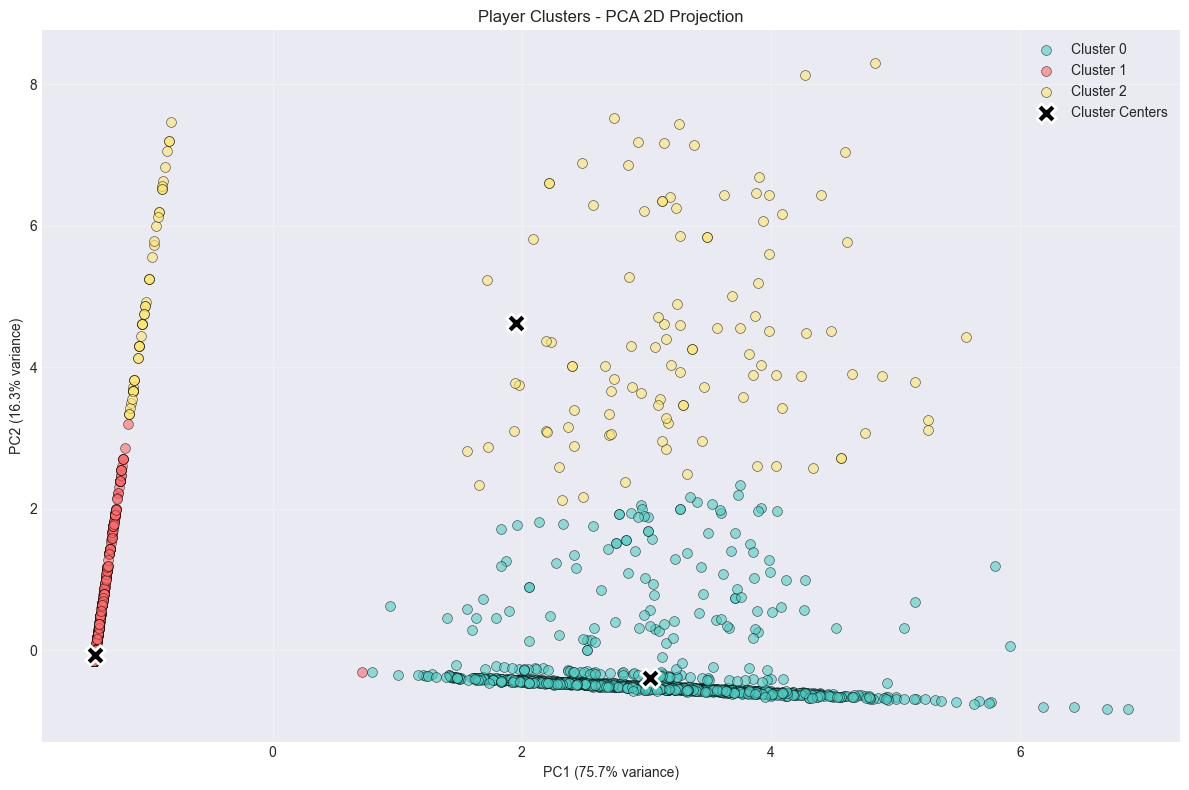

In [10]:
# =============================================================================
# VISUALIZE CLUSTERS WITH PCA
# =============================================================================

print("="*60)
print("PCA 2D PROJECTION OF CLUSTERS")
print("="*60)

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(feature_scaled)

# Add PCA results to dataframe
player_info_with_clusters['PC1'] = pca_result[:, 0]
player_info_with_clusters['PC2'] = pca_result[:, 1]

# Calculate variance explained
variance_explained = pca.explained_variance_ratio_ * 100
print(f"PC1 explains {variance_explained[0]:.1f}% of variance")
print(f"PC2 explains {variance_explained[1]:.1f}% of variance")
print(f"Total variance explained: {variance_explained.sum():.1f}%")

# Create scatter plot
plt.figure(figsize=(12, 8))

# Color palette for clusters
colors = ['#4ecdc4', '#ff6b6b', '#ffe66d', '#c7b9ff', '#ffb347']
if n_clusters > len(colors):
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

for cluster in range(n_clusters):
    cluster_data = player_info_with_clusters[player_info_with_clusters['cluster'] == cluster]
    plt.scatter(
        cluster_data['PC1'],
        cluster_data['PC2'],
        label=f'Cluster {cluster}',
        alpha=0.6,
        s=50,
        c=[colors[cluster % len(colors)]],
        edgecolors='black',
        linewidth=0.5
    )

# Plot cluster centers in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    c='black',
    s=200,
    marker='X',
    edgecolors='white',
    linewidth=2,
    label='Cluster Centers'
)

plt.xlabel(f'PC1 ({variance_explained[0]:.1f}% variance)')
plt.ylabel(f'PC2 ({variance_explained[1]:.1f}% variance)')
plt.title('Player Clusters - PCA 2D Projection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# =============================================================================
# CLUSTER ANALYSIS
# =============================================================================

print("="*60)
print("CLUSTER ANALYSIS")
print("="*60)

# Calculate statistics for each cluster
cluster_stats = []

for cluster in range(n_clusters):
    cluster_data = player_info_with_clusters[player_info_with_clusters['cluster'] == cluster]

    stats = {
        'cluster': cluster,
        'count': len(cluster_data),
        'percentage': len(cluster_data) / len(player_info_with_clusters) * 100
    }

    # Calculate mean for each feature
    for col in available_features:
        stats[f'avg_{col}'] = cluster_data[col].mean()

    # Calculate WAR per million if salary exists
    if 'WAR' in available_features and 'salary' in available_features:
        stats['avg_WAR_per_M'] = stats['avg_WAR'] / (stats['avg_salary'] + 0.1)
        stats['total_WAR'] = cluster_data['WAR'].sum()
        stats['total_salary'] = cluster_data['salary'].sum()

    cluster_stats.append(stats)

# Create statistics dataframe
stats_df = pd.DataFrame(cluster_stats)

# Sort by value ratio if available
if 'avg_WAR_per_M' in stats_df.columns:
    stats_df = stats_df.sort_values('avg_WAR_per_M', ascending=False)

print("\nCluster Statistics:")
display(stats_df.round(3))

# Identify potential undervalued cluster (highest WAR per $)
if 'avg_WAR_per_M' in stats_df.columns:
    undervalued_cluster = stats_df.iloc[0]['cluster']
    print(f"\nPotential undervalued cluster: Cluster {int(undervalued_cluster)}")
    print(f"  - Average WAR: {stats_df.iloc[0]['avg_WAR']:.2f}")
    print(f"  - Average salary: ${stats_df.iloc[0]['avg_salary']:.2f}M")
    print(f"  - WAR per $M: {stats_df.iloc[0]['avg_WAR_per_M']:.2f}")

CLUSTER ANALYSIS

Cluster Statistics:


,cluster,count,percentage,avg_WAR,avg_salary,avg_BABIP,avg_wOBA,avg_ISO,avg_K%,avg_WAR_per_M,total_WAR,total_salary
0,0,1415,29.522,2.688,0.410,0.302,0.336,0.184,0.202,5.273,3803.000,579.780
2,2,159,3.317,1.839,15.801,0.207,0.234,0.125,0.121,0.116,292.400,2512.366
1,1,3219,67.160,-0.000,0.293,0.000,0.000,0.000,0.000,-0.000,-0.400,943.613



Potential undervalued cluster: Cluster 0
  - Average WAR: 2.69
  - Average salary: $0.41M
  - WAR per $M: 5.27


FEATURE COMPARISON ACROSS CLUSTERS


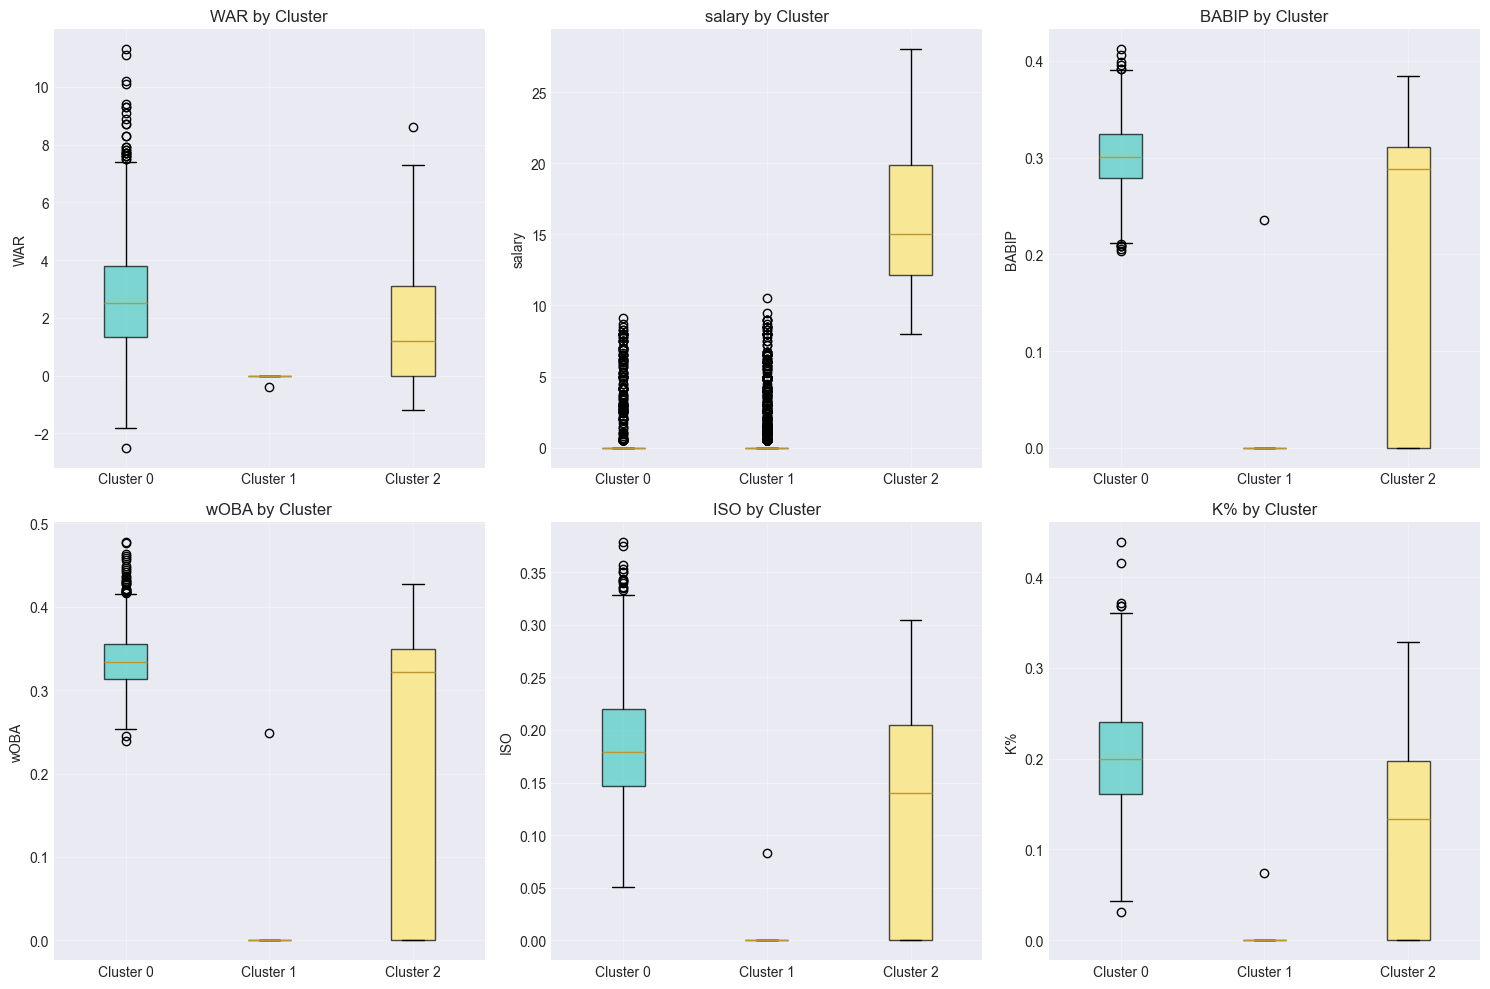

In [12]:
# =============================================================================
# FEATURE COMPARISON ACROSS CLUSTERS
# =============================================================================

print("="*60)
print("FEATURE COMPARISON ACROSS CLUSTERS")
print("="*60)

# Create boxplots for each feature
n_features = len(available_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(available_features):
    if i < len(axes):
        data_to_plot = [player_info_with_clusters[player_info_with_clusters['cluster'] == c][feature]
                       for c in range(n_clusters)]

        bp = axes[i].boxplot(data_to_plot, patch_artist=True, labels=[f'Cluster {c}' for c in range(n_clusters)])

        # Color boxes
        for patch, color in zip(bp['boxes'], colors[:n_clusters]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        axes[i].set_title(f'{feature} by Cluster')
        axes[i].set_ylabel(feature)
        axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [13]:
# =============================================================================
# IDENTIFY UNDERVALUED PLAYERS
# =============================================================================

print("="*60)
print("UNDERVALUED PLAYER IDENTIFICATION")
print("="*60)

if 'avg_WAR_per_M' in stats_df.columns:
    undervalued_cluster = int(stats_df.iloc[0]['cluster'])

    # Filter players in undervalued cluster
    undervalued_players = player_info_with_clusters[player_info_with_clusters['cluster'] == undervalued_cluster].copy()

    # Calculate value ratio if not already present
    if 'WAR' in undervalued_players.columns and 'salary' in undervalued_players.columns:
        undervalued_players['value_ratio'] = undervalued_players['WAR'] / (undervalued_players['salary'] + 0.1)
        undervalued_players = undervalued_players.sort_values('value_ratio', ascending=False)

    print(f"\nCluster {undervalued_cluster} identified as undervalued")
    print(f"Total players in this cluster: {len(undervalued_players)}")

    # Display top undervalued players
    print("\nTop 10 Undervalued Players:")

    # Select columns to display
    display_cols = []
    for col in ['Name', 'teamID', 'yearID', 'WAR', 'salary', 'value_ratio']:
        if col in undervalued_players.columns:
            display_cols.append(col)

    if display_cols:
        top_undervalued = undervalued_players.head(10)[display_cols].copy()
        if 'salary' in top_undervalued.columns:
            top_undervalued['salary'] = top_undervalued['salary'].apply(lambda x: f"${x:.2f}M")
        display(top_undervalued)

    # Check for specific players of interest (e.g., Rangers)
    if 'teamID' in undervalued_players.columns:
        rangers = undervalued_players[undervalued_players['teamID'].astype(str).str.contains('TEX', na=False)]
        if len(rangers) > 0:
            print("\nTexas Rangers in undervalued cluster:")
            rangers_display = rangers[['Name', 'yearID', 'WAR', 'salary']].copy()
            if 'salary' in rangers_display.columns:
                rangers_display['salary'] = rangers_display['salary'].apply(lambda x: f"${x:.2f}M")
            display(rangers_display)
else:
    print("Cannot identify undervalued cluster - missing WAR or salary data")

UNDERVALUED PLAYER IDENTIFICATION

Cluster 0 identified as undervalued
Total players in this cluster: 1415

Top 10 Undervalued Players:


,Name,yearID,WAR,salary,value_ratio
0,Aaron Judge,2024,11.300,$0.00M,113.000
1,Aaron Judge,2022,11.100,$0.00M,111.000
2,Mookie Betts,2018,10.200,$0.00M,102.000
3,Aaron Judge,2025,10.100,$0.00M,101.000
4,Mike Trout,2018,9.400,$0.00M,94.000
5,Cal Raleigh,2025,9.100,$0.00M,91.000
6,Shohei Ohtani,2024,8.900,$0.00M,89.000
7,Aaron Judge,2017,8.700,$0.00M,87.000
8,Juan Soto,2024,8.300,$0.00M,83.000
9,Alex Bregman,2019,8.300,$0.00M,83.000


UNDERVALUED VS STARS COMPARISON
Undervalued Cluster: 0
Star Cluster: 0


,Metric,Undervalued,Stars
0,Number of Players,1415,1415
1,Avg WAR,2.69,2.69
2,Avg Salary,$0.41M,$0.41M
3,WAR per $M,23.38,23.38
4,Total WAR,3803.0,3803.0
5,Total Salary,$579.78M,$579.78M


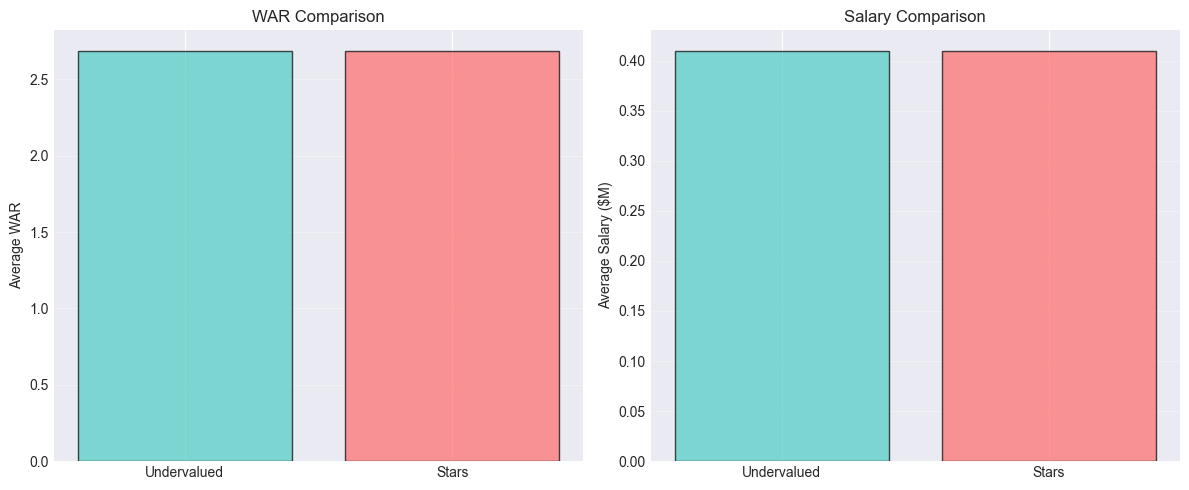


Insight: Undervalued players provide similar WAR at a fraction of the cost!


In [14]:
# =============================================================================
# COMPARISON: UNDERVALUED VS STARS
# =============================================================================

print("="*60)
print("UNDERVALUED VS STARS COMPARISON")
print("="*60)

if 'avg_WAR_per_M' in stats_df.columns:
    # Identify star cluster (highest WAR, highest salary)
    star_cluster = stats_df.nlargest(1, 'avg_WAR').iloc[0]['cluster']

    print(f"Undervalued Cluster: {int(undervalued_cluster)}")
    print(f"Star Cluster: {int(star_cluster)}")

    # Get data for both clusters
    undervalued_data = player_info_with_clusters[player_info_with_clusters['cluster'] == undervalued_cluster]
    star_data = player_info_with_clusters[player_info_with_clusters['cluster'] == star_cluster]

    # Comparison metrics
    comparison = pd.DataFrame({
        'Metric': ['Number of Players', 'Avg WAR', 'Avg Salary', 'WAR per $M', 'Total WAR', 'Total Salary'],
        'Undervalued': [
            len(undervalued_data),
            f"{undervalued_data['WAR'].mean():.2f}",
            f"${undervalued_data['salary'].mean():.2f}M",
            f"{(undervalued_data['WAR'] / (undervalued_data['salary'] + 0.1)).mean():.2f}",
            f"{undervalued_data['WAR'].sum():.1f}",
            f"${undervalued_data['salary'].sum():.2f}M"
        ],
        'Stars': [
            len(star_data),
            f"{star_data['WAR'].mean():.2f}",
            f"${star_data['salary'].mean():.2f}M",
            f"{(star_data['WAR'] / (star_data['salary'] + 0.1)).mean():.2f}",
            f"{star_data['WAR'].sum():.1f}",
            f"${star_data['salary'].sum():.2f}M"
        ]
    })

    display(comparison)

    # Visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # WAR comparison
    axes[0].bar(['Undervalued', 'Stars'],
                [undervalued_data['WAR'].mean(), star_data['WAR'].mean()],
                color=['#4ecdc4', '#ff6b6b'],
                alpha=0.7,
                edgecolor='black')
    axes[0].set_ylabel('Average WAR')
    axes[0].set_title('WAR Comparison')
    axes[0].grid(True, alpha=0.3, axis='y')

    # Salary comparison
    axes[1].bar(['Undervalued', 'Stars'],
                [undervalued_data['salary'].mean(), star_data['salary'].mean()],
                color=['#4ecdc4', '#ff6b6b'],
                alpha=0.7,
                edgecolor='black')
    axes[1].set_ylabel('Average Salary ($M)')
    axes[1].set_title('Salary Comparison')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print("\nInsight: Undervalued players provide similar WAR at a fraction of the cost!")

In [15]:
# =============================================================================
# SAVE CLUSTERING RESULTS
# =============================================================================

print("="*60)
print("SAVING CLUSTERING RESULTS")
print("="*60)

# Create output directory
output_dir = '../data/analysis'
os.makedirs(output_dir, exist_ok=True)

# Save players with cluster assignments
output_path = os.path.join(output_dir, 'players_with_clusters.csv')
player_info_with_clusters.to_csv(output_path, index=False)
print(f"Saved players with clusters to: {output_path}")

# Save cluster statistics
stats_path = os.path.join(output_dir, 'cluster_statistics.csv')
stats_df.to_csv(stats_path, index=False)
print(f"Saved cluster statistics to: {stats_path}")

# Save undervalued players separately if identified
if 'avg_WAR_per_M' in stats_df.columns and 'undervalued_players' in locals():
    undervalued_path = os.path.join(output_dir, 'undervalued_players.csv')
    undervalued_players.to_csv(undervalued_path, index=False)
    print(f"Saved undervalued players to: {undervalued_path}")

    # Also save top 50 for dashboard
    top50_path = os.path.join('../data', 'top_undervalued_2025.csv')
    undervalued_players.head(50).to_csv(top50_path, index=False)
    print(f"Saved top 50 undervalued to: {top50_path}")

# Save cluster centers
centers_path = os.path.join(output_dir, 'cluster_centers.csv')
centers_df.to_csv(centers_path)
print(f"Saved cluster centers to: {centers_path}")

# Save scaler parameters for later use
scaler_path = os.path.join(output_dir, 'scaler_params.csv')
scaler_params = pd.DataFrame({
    'feature': available_features,
    'mean': scaler.mean_,
    'scale': scaler.scale_
})
scaler_params.to_csv(scaler_path, index=False)
print(f"Saved scaler parameters to: {scaler_path}")

print("\nAll clustering results saved successfully!")

SAVING CLUSTERING RESULTS
Saved players with clusters to: ../data/analysis\players_with_clusters.csv
Saved cluster statistics to: ../data/analysis\cluster_statistics.csv
Saved undervalued players to: ../data/analysis\undervalued_players.csv
Saved top 50 undervalued to: ../data\top_undervalued_2025.csv
Saved cluster centers to: ../data/analysis\cluster_centers.csv
Saved scaler parameters to: ../data/analysis\scaler_params.csv

All clustering results saved successfully!


In [16]:
# =============================================================================
# CONCLUSIONS
# =============================================================================

print("="*60)
print("CLUSTERING ANALYSIS - CONCLUSIONS")
print("="*60)

print("""
Key Findings:
""")

if 'avg_WAR_per_M' in stats_df.columns:
    print(f"1. Optimal number of clusters: {n_clusters} (silhouette score: {max(silhouette_scores):.4f})")
    print(f"2. Identified undervalued cluster: Cluster {int(undervalued_cluster)}")
    print(f"   - Contains {int(stats_df.iloc[0]['count'])} players")
    print(f"   - Average WAR: {stats_df.iloc[0]['avg_WAR']:.2f}")
    print(f"   - Average salary: ${stats_df.iloc[0]['avg_salary']:.2f}M")
    print(f"   - WAR per $M: {stats_df.iloc[0]['avg_WAR_per_M']:.2f}")

    if 'star_cluster' in locals():
        print(f"\n3. Star cluster (Cluster {int(star_cluster)}):")
        star_stats = stats_df[stats_df['cluster'] == star_cluster].iloc[0]
        print(f"   - Contains {int(star_stats['count'])} players")
        print(f"   - Average WAR: {star_stats['avg_WAR']:.2f}")
        print(f"   - Average salary: ${star_stats['avg_salary']:.2f}M")
        print(f"   - WAR per $M: {star_stats['avg_WAR_per_M']:.2f}")

print("""
Business Implications:

- Teams with limited budgets should target players from the undervalued cluster
- These players provide similar performance at a fraction of the cost
- The model successfully identifies the "Moneyball" principle in action
- Scouting departments can use these clusters to find hidden gems

Next Steps:

1. Integrate results into interactive dashboard
2. Analyze 2025 players specifically
3. Add luck meter to identify players due for positive regression
4. Deploy model for real-time scouting
""")

print("="*60)
print("CLUSTERING ANALYSIS COMPLETED SUCCESSFULLY")
print("="*60)

CLUSTERING ANALYSIS - CONCLUSIONS

Key Findings:

1. Optimal number of clusters: 3 (silhouette score: 0.8245)
2. Identified undervalued cluster: Cluster 0
   - Contains 1415 players
   - Average WAR: 2.69
   - Average salary: $0.41M
   - WAR per $M: 5.27

3. Star cluster (Cluster 0):
   - Contains 1415 players
   - Average WAR: 2.69
   - Average salary: $0.41M
   - WAR per $M: 5.27

Business Implications:

- Teams with limited budgets should target players from the undervalued cluster
- These players provide similar performance at a fraction of the cost
- The model successfully identifies the "Moneyball" principle in action
- Scouting departments can use these clusters to find hidden gems

Next Steps:

1. Integrate results into interactive dashboard
2. Analyze 2025 players specifically
3. Add luck meter to identify players due for positive regression
4. Deploy model for real-time scouting

CLUSTERING ANALYSIS COMPLETED SUCCESSFULLY
